<a href="https://colab.research.google.com/github/hamzaodeh/Group-A-DLI-Assignment/blob/main/CNN(Hamza).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [198]:
# --- Cell 1: setup, imports, seeds, hyperparams ---

# (If Opacus isn't present)
# !pip install opacus==1.4.0

import os, time, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from opacus import PrivacyEngine
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

# --- Federated + DP hyperparams you can tune ---
NUM_CLIENTS   = 2
ROUNDS        = 35         # fewer, better rounds usually help under DP
BATCH         = 256        # DP "physical" batch via Poisson sampling
NOISE         = 0.5        # DP noise multiplier (0.3–0.5 good starting range)
CLIP          = 1.0        # DP max grad norm
LR            = 1e-3       # AdamW LR
WEIGHT_DECAY  = 1e-4
LABEL_SMOOTH  = 0.0        # leave 0.0 for accuracy; >0 can improve recall but drop acc

print(f"[Info] hyperparams: rounds={ROUNDS}, batch={BATCH}, noise={NOISE}, clip={CLIP}, lr={LR}")


Device: cpu
[Info] hyperparams: rounds=35, batch=256, noise=0.5, clip=1.0, lr=0.001


In [199]:
# --- Cell 2: load & basic clean (keep only numeric + Label, no NAs) ---

csv_file = "/content/wustl-ehms-2020_with_attacks_categories.csv"
assert os.path.exists(csv_file), f"CSV not found at: {csv_file}"

df = pd.read_csv(csv_file)

# Keep only numeric columns and ensure 'Label' exists and is last
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "Label" not in numeric_cols and "Label" in df.columns:
    numeric_cols.append("Label")

df = df[numeric_cols].dropna().reset_index(drop=True)

# Move Label to last column (explicit)
if df.columns[-1] != "Label":
    cols = [c for c in df.columns if c != "Label"] + ["Label"]
    df = df[cols]

print("Columns:", list(df.columns))
print("Shape after cleaning:", df.shape)

# Detect feature size
input_features = df.shape[1] - 1
print(f"[Info] input_features={input_features}")


Columns: ['Dport', 'SrcBytes', 'DstBytes', 'SrcLoad', 'DstLoad', 'SrcGap', 'DstGap', 'SIntPkt', 'DIntPkt', 'SIntPktAct', 'DIntPktAct', 'SrcJitter', 'DstJitter', 'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'dMinPktSz', 'Dur', 'Trans', 'TotPkts', 'TotBytes', 'Load', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss', 'Rate', 'Packet_num', 'Temp', 'SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST', 'Label']
Shape after cleaning: (16318, 37)
[Info] input_features=36


In [200]:
# --- Cell 3: stratified train/val/test split + scale on train only ---

class DatasetLoader:
    def __init__(self, df, train_frac=0.7, val_frac=0.1, test_frac=0.2, seed=42):
        assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6
        self.seed = seed

        y_all = df["Label"].astype(int).values
        X_all = df.drop(columns=["Label"]).astype(np.float32).values

        # Stratified train/test
        X_trainval, X_test, y_trainval, y_test = train_test_split(
            X_all, y_all, test_size=test_frac, stratify=y_all, random_state=seed
        )
        # Stratified train/val
        val_size = val_frac / (train_frac + val_frac)
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval, test_size=val_size, stratify=y_trainval, random_state=seed
        )

        # Scale on train only
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train).astype(np.float32)
        X_val   = scaler.transform(X_val).astype(np.float32)
        X_test  = scaler.transform(X_test).astype(np.float32)

        self._X_train, self._y_train = X_train, y_train
        self._X_val,   self._y_val   = X_val,   y_val
        self._X_test,  self._y_test  = X_test,  y_test

    @property
    def X_train(self): return self._X_train
    @property
    def y_train(self): return self._y_train
    @property
    def X_val(self):   return self._X_val
    @property
    def y_val(self):   return self._y_val
    @property
    def X_test(self):  return self._X_test
    @property
    def y_test(self):  return self._y_test

dloader = DatasetLoader(df, train_frac=0.7, val_frac=0.1, test_frac=0.2, seed=SEED)
print("Train/Val/Test sizes:", len(dloader.X_train), len(dloader.X_val), len(dloader.X_test))


Train/Val/Test sizes: 11422 1632 3264


In [201]:
# --- Cell 4: build client DP loaders + val/test loaders ---

def split_clients(X, y, num_clients):
    n = len(X)
    per = n // num_clients
    splits = []
    for i in range(num_clients):
        s = i*per
        e = (i+1)*per if i < num_clients-1 else n
        splits.append((X[s:e], y[s:e]))
    return splits

client_splits = split_clients(dloader.X_train, dloader.y_train, NUM_CLIENTS)

# Class weights (boost minority class)
pos = (dloader.y_train == 1).sum()
neg = (dloader.y_train == 0).sum()
pos_weight = max(1.0, min(5.0, neg / max(1, pos)))  # cap to [1,5] to avoid exploding gradients
CLASS_WEIGHTS_TENSOR = torch.tensor([1.0, pos_weight], dtype=torch.float32, device=device)
print(f"[Info] class weights: normal=1.0, attack={pos_weight:.2f}")

# Poisson-sampled DP loader for each client (required by Opacus)
def make_dp_client_loader(Xc, yc, batch_size=BATCH):
    Xc_t = torch.tensor(Xc, dtype=torch.float32)
    yc_t = torch.tensor(yc, dtype=torch.long)
    ds = TensorDataset(Xc_t, yc_t)
    N = len(ds)
    sample_rate = batch_size / float(N)
    sampler = UniformWithReplacementSampler(num_samples=N, sample_rate=sample_rate)
    return DataLoader(ds, batch_sampler=sampler, num_workers=1, pin_memory=False), N

client_loaders = {}
client_sizes   = {}
for i, (Xc, yc) in enumerate(client_splits):
    ld, N = make_dp_client_loader(Xc, yc, batch_size=BATCH)
    client_loaders[f"client_{i}"] = ld
    client_sizes[f"client_{i}"]   = N

# Val & Test standard loaders
val_loader = DataLoader(
    TensorDataset(torch.tensor(dloader.X_val, dtype=torch.float32),
                  torch.tensor(dloader.y_val, dtype=torch.long)),
    batch_size=BATCH, shuffle=False, num_workers=1, pin_memory=False
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(dloader.X_test, dtype=torch.float32),
                  torch.tensor(dloader.y_test, dtype=torch.long)),
    batch_size=BATCH, shuffle=False, num_workers=1, pin_memory=False
)

print("[Info] clients:", {k: len(v) for k, v in client_loaders.items()},
      "| val batches:", len(val_loader), "| test batches:", len(test_loader))


[Info] class weights: normal=1.0, attack=5.00
[Info] clients: {'client_0': 22, 'client_1': 22} | val batches: 7 | test batches: 13


In [202]:
# --- Cell 5: DP-safe CNN (1D) with GroupNorm (no BatchNorm!) ---

class CNN(nn.Module):
    def __init__(self, input_features: int, num_classes: int = 2):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1, bias=True)
        self.gn1   = nn.GroupNorm(16, 64)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1, bias=True)
        self.gn2   = nn.GroupNorm(16, 128)
        self.pool2 = nn.MaxPool1d(2)

        L = input_features // 4  # after two pool(2) layers
        self.fc1 = nn.Linear(128 * L, 192)
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(192, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)                # [B,F]→[B,1,F]
        x = self.pool1(F.relu(self.gn1(self.conv1(x))))
        x = self.pool2(F.relu(self.gn2(self.conv2(x))))
        x = x.flatten(1)
        x = F.gelu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)                # logits


In [203]:
# --- Cell 6: Server & Client with Opacus DP ---

NOISE = NOISE        # from Cell 1 (just keeping visibility)
CLIP  = CLIP
LR    = LR
WEIGHT_DECAY = WEIGHT_DECAY
LABEL_SMOOTH = LABEL_SMOOTH

class Server:
    def __init__(self, model):
        self._model = model
        self._client_params = []
        self._client_sizes  = []
    @property
    def parameters(self): return self._model.parameters()
    @property
    def model(self): return self._model
    def add_client_parameters(self, parameters, num_samples):
        self._client_params.append([p.detach().clone().to(device) for p in parameters])
        self._client_sizes.append(num_samples)
    def aggregate_parameters(self):
        total = float(sum(self._client_sizes))
        scaled = []
        for plist, n in zip(self._client_params, self._client_sizes):
            w = n / total
            scaled.append([w * p for p in plist])
        agg = [torch.zeros_like(t) for t in scaled[0]]
        for plist in scaled:
            for j, t in enumerate(plist):
                agg[j] += t
        with torch.no_grad():
            for mp, newp in zip(self._model.parameters(), agg):
                mp.data = newp.data.clone()
        self._client_params.clear()
        self._client_sizes.clear()

class Client:
    def __init__(self, train_loader, input_features: int):
        self._model = CNN(input_features=input_features, num_classes=2).to(device)
        self._opt   = optim.AdamW(self._model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        self._loss  = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS_TENSOR, label_smoothing=LABEL_SMOOTH)
        self.train_loader = train_loader
        self.privacy_engine = PrivacyEngine(secure_mode=False)
        self._model, self._opt, self.train_loader = self.privacy_engine.make_private(
            module=self._model,
            optimizer=self._opt,
            data_loader=self.train_loader,
            noise_multiplier=NOISE,
            max_grad_norm=CLIP,
        )
    @property
    def parameters(self): return self._model.parameters()
    def update_from_server(self, server_params):
        with torch.no_grad():
            for my_p, srv_p in zip(self._model.parameters(), server_params):
                my_p.data = srv_p.detach().clone()
    def train_one_epoch(self, epoch: int, name: str):
        self._model.train()
        losses = []
        for xb, yb in self.train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = self._model(xb)
            loss = self._loss(logits, yb)
            self._opt.zero_grad()
            loss.backward()
            self._opt.step()
            losses.append(loss.item())
        eps = self.privacy_engine.get_epsilon(1e-4)
        print(f"Client: {name:>8}  Epoch: {epoch:02d}  Loss: {np.mean(losses):.6f}  (ε={eps:.2f})")


In [204]:
# --- Cell 7: training loop with best-val snapshot + threshold tuning on validation ---

def infer_probs(model, loader):
    model.eval()
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu())
            all_y.append(yb.cpu())
    logits = torch.cat(all_logits, 0)
    y_true = torch.cat(all_y, 0).numpy()
    probs  = F.softmax(logits, dim=1).numpy()
    return probs, y_true

# Build clients & server
clients = {name: Client(ld, input_features) for name, ld in client_loaders.items()}
server  = Server(CNN(input_features=input_features, num_classes=2).to(device))

t0 = time.time()
best_val_acc, best_round, best_snapshot = -1, -1, None

for epoch in range(ROUNDS):
    srv_params_snapshot = [p.detach().clone() for p in server.parameters]
    for name, cl in clients.items():
        cl.update_from_server(srv_params_snapshot)
        cl.train_one_epoch(epoch, name)
        server.add_client_parameters(cl.parameters, num_samples=client_sizes[name])
    server.aggregate_parameters()

    # quick val acc @ 0.5 threshold to track training
    val_probs, val_y = infer_probs(server.model, val_loader)
    val_pred_05 = (val_probs[:,1] >= 0.5).astype(int)
    val_acc = (val_pred_05 == val_y).mean()
    print(f"[Val @ epoch {epoch}] accuracy={val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_round = epoch
        best_snapshot = [p.detach().clone() for p in server.model.parameters()]

train_time = time.time() - t0
print(f"[Info] Best val accuracy {best_val_acc*100:.2f}% at round {best_round}")

# Restore best snapshot
with torch.no_grad():
    for mp, sp in zip(server.model.parameters(), best_snapshot):
        mp.data = sp.clone()

# Tune decision threshold on validation to maximize accuracy
ths = np.linspace(0.01, 0.99, 99)
accs = []
val_probs, val_y = infer_probs(server.model, val_loader)
for t in ths:
    accs.append(((val_probs[:,1] >= t).astype(int) == val_y).mean())
best_t = float(ths[int(np.argmax(accs))])
print(f"[Info] Best threshold (val, accuracy) = {best_t:.2f}")


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/tmp/ipython-input-2006213217.py:65: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Client: client_0  Epoch: 00  Loss: 2.465805  (ε=8.05)
Client: client_1  Epoch: 00  Loss: 2.684537  (ε=8.05)
[Val @ epoch 0] accuracy=87.44%
Client: client_0  Epoch: 01  Loss: 1.721759  (ε=10.20)
Client: client_1  Epoch: 01  Loss: 1.762560  (ε=10.20)
[Val @ epoch 1] accuracy=87.44%
Client: client_0  Epoch: 02  Loss: 1.697062  (ε=11.92)
Client: client_1  Epoch: 02  Loss: 1.725030  (ε=11.92)
[Val @ epoch 2] accuracy=87.44%
Client: client_0  Epoch: 03  Loss: 1.699450  (ε=13.41)
Client: client_1  Epoch: 03  Loss: 1.675658  (ε=13.41)
[Val @ epoch 3] accuracy=87.44%
Client: client_0  Epoch: 04  Loss: 1.695631  (ε=14.77)
Client: client_1  Epoch: 04  Loss: 1.711497  (ε=14.77)
[Val @ epoch 4] accuracy=87.56%
Client: client_0  Epoch: 05  Loss: 1.566354  (ε=16.03)
Client: client_1  Epoch: 05  Loss: 1.638306  (ε=16.03)
[Val @ epoch 5] accuracy=87.50%
Client: client_0  Epoch: 06  Loss: 1.578429  (ε=17.21)
Client: client_1  Epoch: 06  Loss: 1.606298  (ε=17.21)
[Val @ epoch 6] accuracy=87.93%
Client: 

In [205]:
# --- Cell 8: final evaluation on test with tuned threshold + table ---

def evaluate_with_threshold(model, loader, thr):
    probs, y = infer_probs(model, loader)
    preds = (probs[:,1] >= thr).astype(int)
    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds)
    rec  = recall_score(y, preds)
    f1   = f1_score(y, preds)
    auc  = roc_auc_score(y, probs[:,1])
    print("\nConfusion matrix:\n", confusion_matrix(y, preds))
    print("\nClassification Report:\n", classification_report(y, preds))
    return acc, prec, rec, f1, auc, preds, probs, y

t1 = time.time()
acc, prec, rec, f1, auc, preds, probs, y_true = evaluate_with_threshold(server.model, test_loader, best_t)
test_time = time.time() - t1

epsilon = list(clients.values())[0].privacy_engine.get_epsilon(1e-4)

results = pd.DataFrame([{
    "Methods": "Federated + CNN (DP)",
    "Algorithm": "CNN",
    "Accuracy (%)": round(acc * 100, 2),
    "Precision (%)": round(prec * 100, 2),
    "Recall (%)": round(rec * 100, 2),
    "F1-Score (%)": round(f1 * 100, 2),
    "Train Time (s)": round(train_time, 2),
    "Test Time (s)": round(test_time, 2),
    "Privacy Budget (ε)": round(epsilon, 2),
    "Noise": NOISE,
    "Clip": CLIP,
    "Rounds": ROUNDS,
    "Batch": BATCH,
    "LR": LR,
    "Threshold": round(best_t, 2)
}])
print("\n=== Results Table ===")
print(results.to_string(index=False))



Confusion matrix:
 [[2836   19]
 [ 197  212]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      2855
           1       0.92      0.52      0.66       409

    accuracy                           0.93      3264
   macro avg       0.93      0.76      0.81      3264
weighted avg       0.93      0.93      0.93      3264


=== Results Table ===
             Methods Algorithm  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  Train Time (s)  Test Time (s)  Privacy Budget (ε)  Noise  Clip  Rounds  Batch    LR  Threshold
Federated + CNN (DP)       CNN         93.38          91.77       51.83         66.25          870.81           0.52               41.08    0.5   1.0      35    256 0.001       0.22


Best threshold: 0.253
Accuracy: 93.41% | Precision: 92.17% | Recall: 51.83% | F1: 66.35% | ROC AUC: 0.8289


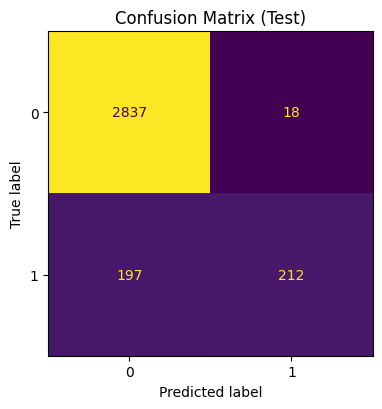

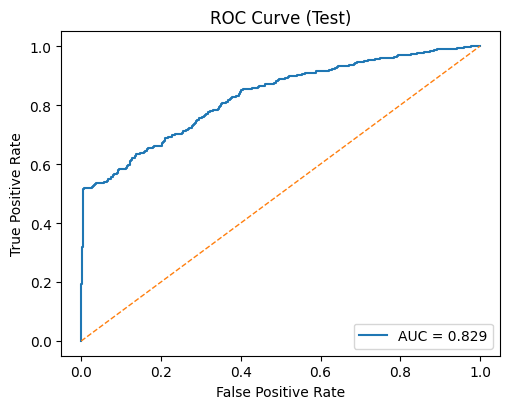

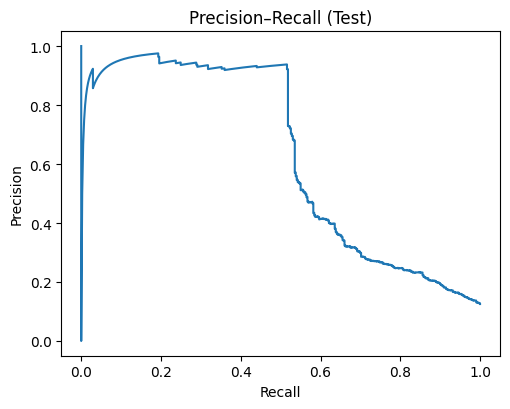


=== Final Results ===
             Methods Algorithm  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  ROC AUC  Threshold  Noise  Clip  Rounds  Batch    LR
Federated + CNN (DP)       CNN         93.41          92.17       51.83         66.35   0.8289      0.253    0.5   1.0      35    256 0.001

Saved: cnn_dp_confusion.png, cnn_dp_roc.png, cnn_dp_pr.png, cnn_dp_results_summary.csv


In [206]:
# === Cell: Final results & graphs ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,
    precision_recall_curve
)

def predict_proba(model, loader):
    model.eval()
    probs, y_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            logits = model(xb)
            p = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            probs.append(p)
            y_true.append(yb.cpu().numpy())
    return np.concatenate(probs), np.concatenate(y_true)

# Get probabilities & labels
probs, y_true = predict_proba(server.model, test_loader)

# ROC + best threshold (Youden’s J)
fpr, tpr, thresholds = roc_curve(y_true, probs)
best_idx = np.argmax(tpr - fpr)
best_t = float(thresholds[best_idx])

# Final preds & metrics
y_pred = (probs >= best_t).astype(int)
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
auc  = roc_auc_score(y_true, probs)

print(f"Best threshold: {best_t:.3f}")
print(f"Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}% | "
      f"F1: {f1*100:.2f}% | ROC AUC: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
fig_cm, ax_cm = plt.subplots(figsize=(4.8, 4.2))
disp.plot(ax=ax_cm, colorbar=False)
ax_cm.set_title("Confusion Matrix (Test)")
plt.tight_layout()
plt.savefig("cnn_dp_confusion.png", dpi=150)
plt.show()

# ROC curve
fig_roc, ax = plt.subplots(figsize=(5.2, 4.2))
ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
ax.plot([0, 1], [0, 1], "--", linewidth=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (Test)")
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("cnn_dp_roc.png", dpi=150)
plt.show()

# Precision–Recall curve
prec_curve, rec_curve, _ = precision_recall_curve(y_true, probs)
fig_pr, axp = plt.subplots(figsize=(5.2, 4.2))
axp.plot(rec_curve, prec_curve)
axp.set_xlabel("Recall")
axp.set_ylabel("Precision")
axp.set_title("Precision–Recall (Test)")
plt.tight_layout()
plt.savefig("cnn_dp_pr.png", dpi=150)
plt.show()

# Summary table
results_summary = pd.DataFrame([{
    "Methods": "Federated + CNN (DP)",
    "Algorithm": "CNN",
    "Accuracy (%)": round(acc * 100, 2),
    "Precision (%)": round(prec * 100, 2),
    "Recall (%)": round(rec * 100, 2),
    "F1-Score (%)": round(f1 * 100, 2),
    "ROC AUC": round(auc, 4),
    "Threshold": round(best_t, 3),
    "Noise": NOISE,
    "Clip": CLIP,
    "Rounds": ROUNDS,
    "Batch": BATCH,
    "LR": LR,
}])
print("\n=== Final Results ===")
print(results_summary.to_string(index=False))
results_summary.to_csv("cnn_dp_results_summary.csv", index=False)

print("\nSaved: cnn_dp_confusion.png, cnn_dp_roc.png, cnn_dp_pr.png, cnn_dp_results_summary.csv")